In [ ]:
# Model Structure 

# Input layer 
# conv2d_CV
# max_pool_2d_CV
# fully connected layer 
# output 


# Unable to fully implement due to time constrains 

### Loading dataset

In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt 
import numpy as np

# Loading datasets 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# hyper parameter
num_epochs = 4 
batch_size = 4
learning_rate = 0.001


transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

train_data = torchvision.datasets.CIFAR10(root='./data',train=True,
                                             download=True,transform=transform)

test_data = torchvision.datasets.CIFAR10(root='./data',train=False,
                                             download=True,transform=transform)

train_loader =torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader =torch.utils.data.DataLoader(dataset=test_data, 
                                           batch_size=batch_size,
                                           shuffle=True)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


torch.Size([4, 3, 32, 32])
torch.Size([3, 32, 32])


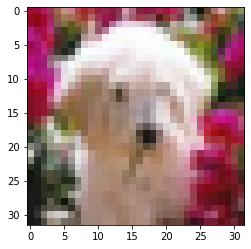

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.__next__()

print(images.shape)
print(images[0].shape)
imshow(images[1])

In [ ]:
test_im = images[0]

In [ ]:
test_im = images[0]
kernel = np.random.randn(3,3)

for i in range(images[0].shape[0]):
  print("input kernel:" , i+1)
  # output = conv2d(test_im[i] , kernel)

input kernel: 1
input kernel: 2
input kernel: 3


### Conv2d layer 

In [ ]:
class conv_2D_CV:
    def __init__(self, in_channels, out_channels, kernel_size, padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        
        # Initialize weights and biases
        self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size)
        self.biases = np.zeros((out_channels, 1))
    
    def forward(self, x):
        # applying padding 
        x_padded = np.pad(x, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)))
        print("x_padded", x_padded.shape)


        # output dimensions calculated here
        # From cifar 10 dataset, we expect the shape of a single image to be 
        # (batch, channel, height, width)

        batch_size, in_channels, in_height, in_width = x.shape
        out_height = in_height + 2*self.padding - self.kernel_size + 1 # formula for calculating output shape 
        out_width = in_width + 2*self.padding - self.kernel_size + 1
        
        # Initialize output shape - to store convolution output 
        out = np.zeros((batch_size, self.out_channels, out_height, out_width))
        print("output shape:", out.shape)

        # Convolution operation 
        for b in range(batch_size):
            for c in range(self.out_channels):
                for i in range(out_height):
                    for j in range(out_width):
                        # Extract the current patch
                        conv_patch = x_padded[b, :, i:i+self.kernel_size, j:j+self.kernel_size]
  
                  
                        out[b, c, i, j] = np.sum(conv_patch * self.weights[c]) + self.biases[c]
        print("conv_patch", conv_patch.shape)
        return out

    def backprop(self, x, dout, lr):
        self.lr = lr 
        # Pad the input tensor
        x_padded = np.pad(x, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)))
        
        # Assigning gradient variables for input, weights and bias 
        dx = np.zeros_like(x)
        dw = np.zeros_like(self.weights)
        db = np.zeros_like(self.biases)
        
        # Calculating gradients
        for b in range(x.shape[0]):
            for c in range(self.out_channels):
                for i in range(dout.shape[2]):
                    for j in range(dout.shape[3]):
                        # Extracting the current patch
                        patch = x_padded[b, :, i:i+self.kernel_size, j:j+self.kernel_size]
                        
                        # updating the gradient for the weights, bias and input 
                        dw[c] += patch * dout[b, c, i, j]
                        db[c] += dout[b, c, i, j]
                        dx[b, :, i:i+self.kernel_size, j:j+self.kernel_size] += self.weights[c] * dout[b, c, i, j]
        
        # Remove padding from dx
        dx = dx[:, :, self.padding:-self.padding, self.padding:-self.padding]
        
        # updating weights and biases
        self.weights -= self.lr * dw / x.shape[0]
        self.biases -= self.lr * db / x.shape[0]
        
        return dx





In [ ]:
test_shape = images.shape
print(test_shape)
test_shape[0]  # batch, channel , height, width 

torch.Size([4, 3, 32, 32])


4

In [ ]:
# Testing class - testing forward prop 
conv1 = conv_2D_CV(in_channels=test_shape[1], out_channels=3, kernel_size=3, padding=0)
conv_output = conv1.forward(test_im.unsqueeze(0))
conv_output.shape

x_padded (1, 3, 32, 32)
output shape: (1, 3, 30, 30)
conv_patch (3, 3, 3)


(1, 3, 30, 30)

In [ ]:
type(conv_output)

numpy.ndarray

#### Manually testing functions 

In [ ]:
# Testing class - testing forward/backprop 

# Generate some random input and output tensors
# x = np.random.randn(1, 3, 32, 32)
y = np.random.randn(1, 16, 30, 30)

# x = images[0]
# y = images[1]
test_im = images[0]
target_im = images[1]


conv1 = conv_2D_CV(in_channels=test_shape[1], out_channels=16, kernel_size=3, padding=0)
# Compute the forward pass
out = conv1.forward(test_im.unsqueeze(0))
# Converting numpy array to tensor 
# out = torch.from_numpy(out)
print("out shape:", out.shape)



# Compute the loss and the gradient with respect to the output
loss = np.sum((out - y) ** 2)

dout = 2 * (out - y)
print("dout shape:", dout.shape)
print("input shape", test_im.shape)

# Compute the gradient with respect to the input
dx = conv1.backprop(test_im.unsqueeze(0), dout, 0.001)

# Print the loss and the gradients
print('Loss:', loss)
print('dout shape:', dout.shape)
print('dx shape:', dx.shape)


print(type(out))
print(type(dout))

x_padded (1, 3, 32, 32)
output shape: (1, 16, 30, 30)
conv_patch (3, 3, 3)
out shape: (1, 16, 30, 30)
dout shape: (1, 16, 30, 30)
input shape torch.Size([3, 32, 32])
Loss: 56922.023858094835
dout shape: (1, 16, 30, 30)
dx shape: (1, 3, 0, 0)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Max pooling layer

In [ ]:
class max_pool_2d_CV: 

  def __init__(self, x, pool_size=2):
    self.input = x 
    self.pool_size = pool_size
    self.cache = (x.shape[0], x.shape[1], x.shape[2], x.shape[3]) 


  def forward(self, x):
    self.input = x 
    batch_size, channel, height, width = self.input.shape
    pool_height = self.pool_size
    pool_width = self.pool_size

    # output dimensions 
    out_height = height // pool_height
    out_width = width // pool_width

    # Initialize output shape - to store convolution output 
    out = np.zeros((batch_size, channel, out_height, out_width))
    print("output shape:", out.shape)

    # Applying Max pooling operation 
    for b in range(batch_size):
      for c in range(channel):
        for i in range(out_height):
          for j in range(out_width): 
            pool_slice = self.input[b, c, i*pool_height:(i+1)*pool_height, j*pool_width:(j+1)*pool_width]
            
            # converting tensor into numpy array 
            np_out = pool_slice.cpu().detach().numpy()
            
            out[b, c, i, j] = np.max(np_out)

    return out 


  def backprop(self,output):
    self.output = output 
    batch_size, channel, height, width = self.output.shape
    pool_height = self.pool_size
    pool_width = self.pool_size

    # Initialize output shape
    out_grad = np.zeros((batch_size, channel, out_height, out_width))
    print("output shape:", out_grad.shape)


    for b in range(batch_size):
      for c in range(channel):
        for i in range(out_height):
          for j in range(out_width): 
            # Find the indices of the max value in the pool
            pool_slice = self.input[b, c, i*pool_height:(i+1)*pool_height, j*pool_width:(j+1)*pool_width]
            max_indices = np.unravel_index(np.argmax(pool_slice), pool_slice.shape)

            out_grad[b, c, i*pool_height+max_indices[0], j*pool_width+max_indices[1]] = 1




    return out_grad 

In [ ]:
maxpool1 = max_pool_2d_CV(x=test_im.unsqueeze(0),pool_size=2)
out1 = maxpool1.forward(x=test_im.unsqueeze(0))
out1.shape

output shape: (1, 3, 16, 16)


(1, 3, 16, 16)

#### Manually testing functions 

Error in backprop

In [ ]:
# Testing max pool - forward 

x=test_im.unsqueeze(0)
print("input shape:", x.shape)
pool_size = 2 

batch_size, channel, height, width = x.shape
pool_height = pool_size
pool_width = pool_size

# output dimensions 
out_height = height // pool_height
out_width = width // pool_width

out_height
# # Initialize output shape - to store convolution output 
out = np.zeros((batch_size, channel, out_height, out_width))
print("output shape:", out.shape)

# Applying Max pooling operation 
for b in range(batch_size):
  for c in range(channel):
    for i in range(out_height):
      for j in range(out_width): 
        pool_slice = x[b, c, i*pool_height:(i+1)*pool_height, j*pool_width:(j+1)*pool_width]

        # converting tensor into numpy array 
        np_out = pool_slice.cpu().detach().numpy()

        out[b, c, i, j] = np.max(np_out)



input shape: torch.Size([1, 3, 32, 32])
output shape: (1, 3, 16, 16)


In [ ]:
# Testing backprop 

y = np.random.randn(1, 3, 16, 16)

# x = images[0]
# y = images[1]
test_im = images[0]
target_im = images[1]



maxpool1 = max_pool_2d_CV(x=test_im.unsqueeze(0),pool_size=2)
out1 = maxpool1.forward(x=test_im.unsqueeze(0))
out1.shape

print("out shape:", out1.shape)



# # Compute the loss and the gradient with respect to the output
loss = np.sum((out1 - y) ** 2)

dout = 2 * (out1 - y)
print("dout shape:", dout.shape)
print("input shape", test_im.shape)


# Compute the gradient with respect to the input
dx = maxpool1.backprop(dout)

# # Print the loss and the gradients
# print('Loss:', loss)
# print('dout shape:', dout.shape)
# print('dx shape:', dx.shape)


# print(type(out))
# print(type(dout))

output shape: (1, 3, 16, 16)
out shape: (1, 3, 16, 16)
dout shape: (1, 3, 16, 16)
input shape torch.Size([3, 32, 32])
output shape: (1, 3, 16, 16)


IndexError: ignored

In [ ]:
# Testing max pool - backprop 
output = out
batch_size, channel, height, width = output.shape
pool_height = pool_size
pool_width = pool_size



# Initialize output shape
grad = np.zeros((batch_size, channel, out_height, out_width))
print("output shape:", out_grad.shape)


for b in range(batch_size):
  for c in range(channel):
    for i in range(out_height):
      for j in range(out_width): 
        # Finds the index of where the max value is located 
        pool_slice = x[b, c, i*pool_height:(i+1)*pool_height, j*pool_width:(j+1)*pool_width]
        max_indices = np.unravel_index(np.argmax(pool_slice), pool_slice.shape)
        
        # Assigning max val 
        grad[b, c, i*pool_height+max_indices[0], j*pool_width+max_indices[1]] = 1





output shape: (1, 3, 16, 16)


IndexError: ignored

In [ ]:
print(grad.shape)
print(output.shape)

pool_slice
# max_indices

(1, 3, 16, 16)
(1, 3, 16, 16)


tensor([[0.2706, 0.2941],
        [0.4431, 0.4353]])

In [ ]:
print(np.argmax(pool_slice))
print(pool_slice.shape)
print(max_indices)
output.shape

tensor(2)
torch.Size([2, 2])
(1, 0)


(1, 3, 16, 16)

In [ ]:
test_im = images[0]
test_im.shape
x=test_im.unsqueeze(0)
x.shape
print(type(pool_slice))
print(pool_slice)


np_arr = pool_slice.cpu().detach().numpy()
maximus = np.max(np_arr)
maximus

<class 'torch.Tensor'>
tensor([[0.2706, 0.2941],
        [0.4431, 0.4353]])


0.4431373